# CS4287 Assignment 2 Option 2: Deep Q-Learning for Space Invaders

**Team Members:** Michael Cronin (22336842), Darren Nugent ()  
**Code Executes to End:** Yes  
**Third-Party Code:** Original implementation based on DQN architecture from Mnih et al. (2015) and Double DQN from van Hasselt et al. (2016). No external DQN libraries used.

---

## Table of Contents

1. [Why Reinforcement Learning](#1-why-reinforcement-learning-for-space-invaders) (3 marks)
2. [The Gymnasium Environment](#2-the-gymnasium-environment-space-invaders) (3 marks)
3. [Implementation](#3-implementation)
   - 3.1 Data Preprocessing (3 marks)
   - 3.2 Network Architecture (4 marks)
   - 3.3 Q-Learning Update (3 marks)
4. [Training Plots](#4-training-plots) (3 marks)
5. [Video Recording](#5-video-recording) (1 mark)
6. [Evaluation of Results](#6-evaluation-of-results) (5 marks)
7. [Independent Research: Double DQN](#7-independent-research-double-dqn-and-maximization-bias) (5 marks)
8. [Training and Results](#8-training-and-results)
9. [References](#9-references)

## 1. Why Reinforcement Learning for Space Invaders

Space Invaders requires an agent to make sequential decisions in a dynamic environment where actions have delayed consequences. Reinforcement Learning is the appropriate paradigm for several reasons:

**Sequential Decision Making:** The game requires planning over time - positioning to avoid alien fire while targeting specific aliens for maximum points. RL naturally handles this through its framework of states, actions, and cumulative rewards.

**Trial and Error Learning:** Like a human player, an RL agent learns through interaction with the game environment. It discovers that shooting aliens yields rewards while getting hit ends the episode, without requiring explicit programming of these rules.

**High-Dimensional Visual Input:** The game state is represented as 210×160 RGB images. Deep Q-Networks combine deep learning's ability to process high-dimensional inputs with RL's sequential decision-making framework.

**Delayed Rewards:** Strategic decisions like preserving shields or targeting the mystery ship require understanding delayed consequences - a core strength of RL's reward accumulation over time.

**Dynamic Difficulty:** As aliens are destroyed, the remaining ones speed up. RL agents continuously update their policy based on the current state, naturally adapting to this increasing difficulty.

## 2. The Gymnasium Environment: Space Invaders

### Environment Specification
- **Environment ID:** ALE/SpaceInvaders-v5
- **Observation Space:** Box(0, 255, (210, 160, 3), uint8) - RGB frames
- **Action Space:** Discrete(6)
- **Lives:** 3 per episode

### Action Space
Space Invaders provides 6 discrete actions:

| Action ID | Action Name | Description |
|-----------|-------------|-------------|
| 0 | NOOP | No operation |
| 1 | FIRE | Shoot while stationary |
| 2 | RIGHT | Move right |
| 3 | LEFT | Move left |
| 4 | RIGHTFIRE | Move right and shoot |
| 5 | LEFTFIRE | Move left and shoot |

### Reward Structure
Points are awarded for destroying aliens, with higher rows worth more:

| Target | Points |
|--------|--------|
| Bottom row aliens | 10 |
| Second row | 20 |
| Third row | 30 |
| Top row aliens | 40 |
| Mystery ship (UFO) | 50-200 (random) |

### Role in Training
The environment provides 210×160×3 RGB observations at each timestep. These raw frames are preprocessed to 84×84 grayscale images and stacked in groups of 4 to provide temporal information about motion and velocity. The reward signal guides the agent's policy optimization through the Q-learning algorithm.

In [1]:
!pip install ale_py
!pip install gymnasium[atari]
!pip install matplotlib
!pip install imageio
!pip install imageio-ffmpeg

In [2]:
import ale_py
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


# Create the envirnment
gym.register_envs(ale_py)
env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [3]:
# Environment analysis
obs, info = env.reset()

print(f"OBSERVATION SPACE")
print(f"Shape: {obs.shape}")
print(f"Data type: {obs.dtype}")
print(f"Min value: {obs.min()}, Max value: {obs.max()}")
print(f"Total pixels: {np.prod(obs.shape):,}")

print(f"\nACTION SPACE")
print(f"Type: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")

OBSERVATION SPACE
Shape: (210, 160, 3)
Data type: uint8
Min value: 0, Max value: 181
Total pixels: 100,800

ACTION SPACE
Type: Discrete(6)
Number of actions: 6


In [4]:
# See what each action does
action_meanings = env.unwrapped.get_action_meanings()
for i, action in enumerate(action_meanings):
    print(f"Action {i}: {action}")

Action 0: NOOP
Action 1: FIRE
Action 2: RIGHT
Action 3: LEFT
Action 4: RIGHTFIRE
Action 5: LEFTFIRE


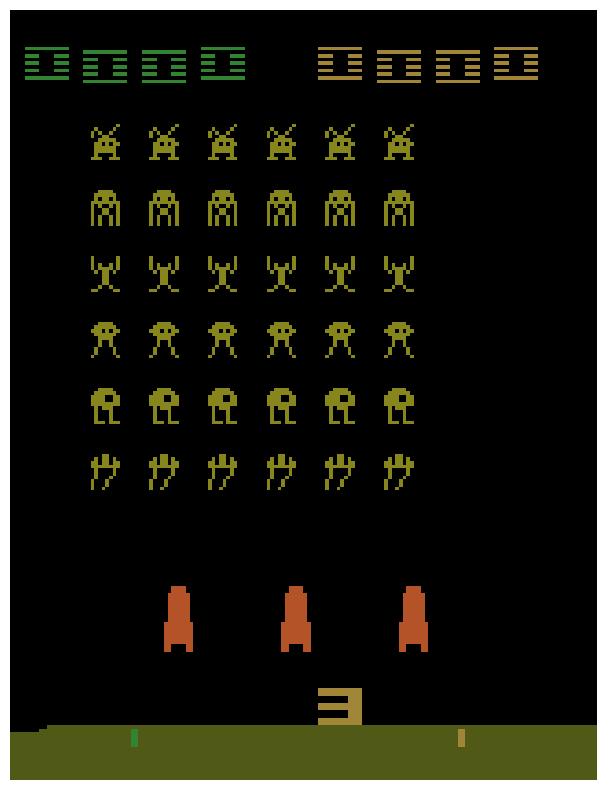

In [5]:
# Visulaise initial state
plt.figure(figsize=(8, 10))
plt.imshow(obs)
plt.axis('off')
plt.show()

In [6]:
env.close()

## 3. Implementation

### 3.1 Data Preprocessing

Raw Atari frames are 210×160×3 RGB images, which is computationally expensive and contains unnecessary information. Our preprocessing pipeline applies the following transformations:

1. **Frame skip (k=3):** Unlike most Atari games which use k=4, Space Invaders requires k=3 because the laser projectiles blink at a frequency that makes them invisible with k=4 (this is the only hyperparameter difference noted in the original DQN paper)
2. **Cropping:** Remove score display and ground (rows 20-195), reducing visual noise
3. **Grayscale conversion:** Reduce from 3 channels to 1 (color not needed for gameplay)
4. **Resize:** Downsample to 84×84 for computational efficiency
5. **Normalization:** Scale pixel values from [0, 255] to [0, 1]
6. **Frame stacking:** Stack 4 consecutive frames to capture motion and velocity information

This reduces the input from 100,800 values per frame to 7,056 values per frame, while the 4-frame stack provides temporal context that allows the network to perceive movement.

In [7]:
!pip install opencv-python
!pip install torch

In [8]:
import gymnasium as gym
import numpy as np
import cv2
from collections import deque

class SpaceInvadersPreprocessor(gym.Wrapper):
    def __init__(self, env, frame_stack=4, im_size=84):
        super().__init__(env)
        self.frame_stack = frame_stack
        self.im_size = im_size
        self.frames = deque(maxlen=frame_stack)
        
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(frame_stack, im_size, im_size),
            dtype=np.float32
        )
    
    def preprocess_frame(self, frame):
        # Crop, grayscale, resize, normalize
        cropped = frame[20:195, :]
        gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (self.im_size, self.im_size), 
                            interpolation=cv2.INTER_AREA)
        normalised = resized.astype(np.float32) / 255.0
        return normalised
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        processed = self.preprocess_frame(obs)
        
        for _ in range(self.frame_stack):
            self.frames.append(processed)
        
        return np.array(self.frames, dtype=np.float32), info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        processed = self.preprocess_frame(obs)
        self.frames.append(processed)
        
        return np.array(self.frames, dtype=np.float32), reward, terminated, truncated, info


# Quick test
env = gym.make('ALE/SpaceInvaders-v5', frameskip=3)
env = SpaceInvadersPreprocessor(env)
state, _ = env.reset()
print(f"State shape: {state.shape}, range: [{state.min():.2f}, {state.max():.2f}]")
env.close()

State shape: (4, 84, 84), range: [0.00, 0.52]


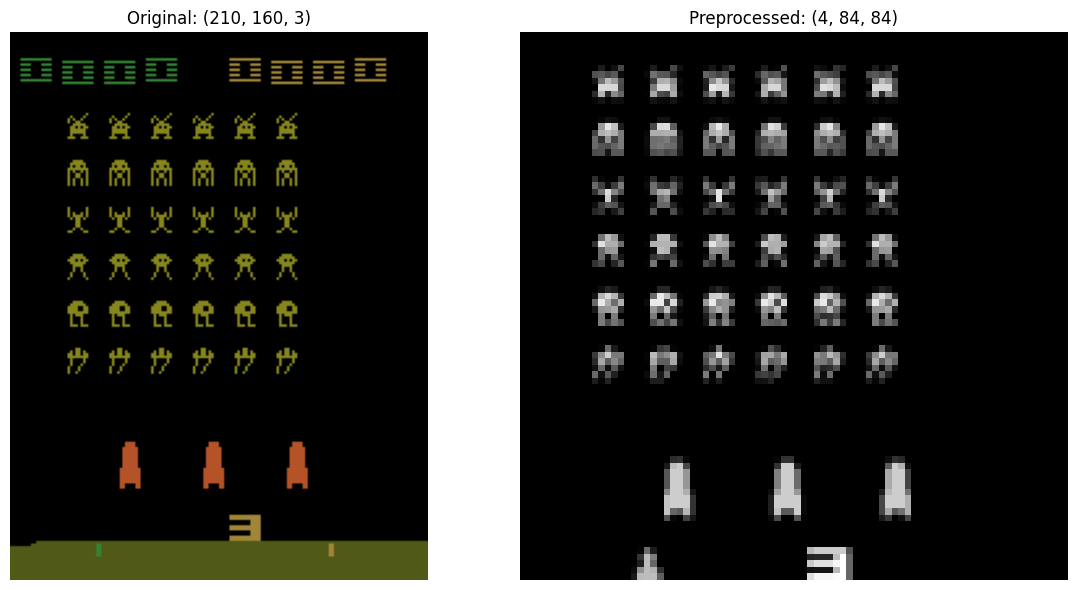

Original: (210, 160, 3), dtype=uint8, range=[0, 181]
Preprocessed: (4, 84, 84), dtype=float32, range=[0.00, 0.52]


In [9]:
import matplotlib.pyplot as plt
import gymnasium as gym

# Create environments
env_orig = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3)
env_wrap = SpaceInvadersPreprocessor(gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3))

# Get frames
orig_frame, _ = env_orig.reset(seed=42)
preprocessed, _ = env_wrap.reset(seed=42)

# Take a few steps to see actual gameplay
for _ in range(15):
    orig_frame, _, _, _, _ = env_orig.step(1)  # FIRE action
    preprocessed, _, _, _, _ = env_wrap.step(1)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(orig_frame)
ax1.set_title(f'Original: {orig_frame.shape}')
ax1.axis('off')

ax2.imshow(preprocessed[0], cmap='gray')  # Show first frame from stack
ax2.set_title(f'Preprocessed: {preprocessed.shape}')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Original: {orig_frame.shape}, dtype={orig_frame.dtype}, range=[{orig_frame.min()}, {orig_frame.max()}]")
print(f"Preprocessed: {preprocessed.shape}, dtype={preprocessed.dtype}, range=[{preprocessed.min():.2f}, {preprocessed.max():.2f}]")

env_orig.close()
env_wrap.close()

### 3.2 Network Architecture

The DQN follows the architecture from Mnih et al. (2015):

**Convolutional Layers:**
- Conv1: 32 filters, 8×8 kernel, stride 4 → extracts low-level features (edges, shapes)
- Conv2: 64 filters, 4×4 kernel, stride 2 → mid-level features (alien patterns, shields)
- Conv3: 64 filters, 3×3 kernel, stride 1 → high-level features (spatial relationships)

**Fully Connected Layers:**
- FC1: 3136 → 512 neurons with ReLU activation
- FC2: 512 → 6 neurons (Q-values for each action)

The convolutional layers extract spatial features from the stacked frames, while the fully connected layers map these features to action values. ReLU activations introduce non-linearity, allowing the network to learn complex policies.

**Hyperparameter Summary:**

| Parameter | Value | Notes |
|-----------|-------|-------|
| Replay buffer size | 100,000 | Stores recent transitions |
| Batch size | 32 | Samples per training step |
| Discount factor (γ) | 0.99 | High value for long-term planning |
| Learning rate | 1e-4 | Adam optimizer |
| Initial epsilon | 1.0 | Start with full exploration |
| Final epsilon | 0.01 | End with 1% exploration |
| Epsilon decay | 0.9995 | Multiplicative decay per step |
| Target network update | 1000 steps | Hard update frequency |
| Frame skip | 3 | Space Invaders specific |
| Frame stack | 4 | Temporal context |

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, n_actions=6):
        super(DQN, self).__init__()
        
        # Conv layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # FC layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, n_actions)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# Test it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN(n_actions=6).to(device)

# Test with dummy input (batch of 1, 4 frames, 84x84)
test_input = torch.randn(1, 4, 84, 84).to(device)
output = model(test_input)
print(f"Input: {test_input.shape}, Output: {output.shape}")
print(f"Running on: {device}")

Input: torch.Size([1, 4, 84, 84]), Output: torch.Size([1, 6])
Running on: cuda


In [11]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(np.array(states)),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(dones)
        )
    
    def __len__(self):
        return len(self.buffer)


# Test
buffer = ReplayBuffer(capacity=1000)
buffer.push(np.random.rand(4, 84, 84), 2, 10, np.random.rand(4, 84, 84), False)
print(f"Buffer size: {len(buffer)}")

Buffer size: 1


### 3.3 Q-Learning Update Mechanism
 
 The core of DQN is the Q-learning update, implemented in `train_step()`. Here's exactly how it works:
 
 **The Bellman Equation:**
 The optimal Q-value for a state-action pair satisfies:
 ```
 Q*(s, a) = r + γ * max_a' Q*(s', a')
 ```
 Where `r` is the immediate reward, `γ` (gamma) is the discount factor, and `s'` is the next state.
 
 **Step-by-step through train_step():**
 
 1. **Sample batch from replay buffer:** We randomly sample 32 transitions (s, a, r, s', done) to break correlation between consecutive experiences.
 
 2. **Compute current Q-values:** `current_q = online_net(states).gather(1, actions)` - The network outputs Q-values for ALL actions, then `.gather()` selects only the Q-values for actions we actually took.
 
 3. **Compute target Q-values:**
    - **Standard DQN:** `next_q = target_net(next_states).max(1)[0]` - Target network estimates max Q-value at next state
    - **Double DQN:** Online network SELECTS best action, target network EVALUATES it - this reduces overestimation bias
    - `target_q = rewards + gamma * next_q * (1 - dones)` - If done=1 (terminal), future reward is zero
 
 4. **Compute loss:** `F.smooth_l1_loss(current_q, target_q)` - Huber loss is more robust to outliers than MSE, preventing large gradient updates from unusual experiences.
 
 5. **Backpropagate and update:** Standard gradient descent with gradient clipping (max_norm=10) for stability.
 
 6. **Update target network:** Every 1000 steps, copy online network weights to target network. This provides stable targets during training.
 
**Why Two Networks?**
Without a separate target network, we'd be updating towards a moving target (since the same network provides both predictions and targets). The target network provides stable Q-value estimates for several thousand steps.

In [12]:
class DQNAgent:
    def __init__(self, n_actions=6, double_dqn=False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_actions = n_actions
        self.double_dqn = double_dqn  # Toggle for Double DQN
        
        # Networks
        self.online_net = DQN(n_actions).to(self.device)
        self.target_net = DQN(n_actions).to(self.device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        
        # Training
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=1e-4)
        self.replay_buffer = ReplayBuffer(capacity=100000)
        
        # Hyperparameters
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.batch_size = 32
        self.target_update_freq = 1000
        self.steps = 0
    
    def choose_action(self, state, training=True):
        # Epsilon-greedy
        if training and random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.online_net(state_tensor)
            return q_values.argmax().item()
    
    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        
        # Current Q values
        current_q = self.online_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Target Q values
        with torch.no_grad():
            if self.double_dqn:
                # Double DQN: online network selects, target network evaluates
                next_actions = self.online_net(next_states).argmax(1, keepdim=True)
                next_q = self.target_net(next_states).gather(1, next_actions).squeeze(1)
            else:
                # Standard DQN: target network does both
                next_q = self.target_net(next_states).max(1)[0]
            
            target_q = rewards + self.gamma * next_q * (1 - dones)
        
        # Compute loss and update
        loss = F.smooth_l1_loss(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), max_norm=10)
        self.optimizer.step()
        
        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.online_net.state_dict())
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()

In [ ]:
def train(episodes=1000, log_interval=10, double_dqn=False, save_dir='outputs'):
    """
    Train a DQN agent on Space Invaders.
    
    Returns:
        agent: Trained DQNAgent
        history: Dict containing episode_rewards, losses, epsilons, q_values
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    env = gym.make('ALE/SpaceInvaders-v5', frameskip=3)
    env = SpaceInvadersPreprocessor(env)
    agent = DQNAgent(n_actions=6, double_dqn=double_dqn)
    
    mode = 'double_dqn' if double_dqn else 'standard_dqn'
    print(f"Training {mode.replace('_', ' ').title()} on {agent.device}")
    
    history = {
        'episode_rewards': [],
        'losses': [],
        'epsilons': [],
        'avg_q_values': [],
        'episode_lengths': []
    }
    
    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_loss = []
        episode_q_values = []
        steps = 0
        done = False
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.replay_buffer.push(state, action, reward, next_state, float(done))
            
            loss = agent.train_step()
            if loss is not None:
                episode_loss.append(loss)
                
                # Track Q-values periodically
                if steps % 100 == 0:
                    with torch.no_grad():
                        state_t = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                        q_vals = agent.online_net(state_t)
                        episode_q_values.append(q_vals.max().item())
            
            state = next_state
            episode_reward += reward
            steps += 1
        
        # Record history
        history['episode_rewards'].append(episode_reward)
        history['losses'].append(np.mean(episode_loss) if episode_loss else 0)
        history['epsilons'].append(agent.epsilon)
        history['avg_q_values'].append(np.mean(episode_q_values) if episode_q_values else 0)
        history['episode_lengths'].append(steps)
        
        if episode % log_interval == 0:
            avg_reward = np.mean(history['episode_rewards'][-100:])
            avg_loss = np.mean(history['losses'][-100:]) if history['losses'] else 0
            print(f"Episode {episode:4d} | Reward: {episode_reward:6.0f} | "
                  f"Avg100: {avg_reward:7.1f} | Loss: {avg_loss:.4f} | "
                  f"Epsilon: {agent.epsilon:.3f}")
        
        # Save checkpoints
        if episode > 0 and episode % 100 == 0:
            checkpoint_path = f'{save_dir}/dqn_{mode}_ep{episode}.pth'
            torch.save({
                'episode': episode,
                'model_state_dict': agent.online_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon,
                'history': history
            }, checkpoint_path)
            print(f"  Saved checkpoint: {checkpoint_path}")
    
    # Save final model
    final_path = f'{save_dir}/dqn_{mode}_final.pth'
    torch.save({
        'model_state_dict': agent.online_net.state_dict(),
        'history': history
    }, final_path)
    
    env.close()
    return agent, history

 ## 4. Training Plots
 
 The following visualizations track the agent's learning progress:
 - **Episode Rewards:** Raw and smoothed rewards over training
 - **Loss Curve:** TD error magnitude over time
 - **Epsilon Decay:** Exploration rate schedule
 - **Q-Value Estimates:** Average predicted Q-values (indicator of value learning)

In [14]:
def plot_training_curves(history, title_prefix='DQN', save_path=None):
    """Generate comprehensive training visualization."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Episode Rewards with multiple moving averages
    ax1 = axes[0, 0]
    rewards = history['episode_rewards']
    ax1.plot(rewards, alpha=0.3, color='blue', label='Raw')
    
    for window, color in [(50, 'orange'), (100, 'red')]:
        if len(rewards) >= window:
            ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(rewards)), ma, 
                    label=f'{window}-Episode MA', color=color, linewidth=2)
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title(f'{title_prefix}: Episode Rewards')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Training Loss
    ax2 = axes[0, 1]
    losses = history['losses']
    ax2.plot(losses, alpha=0.3, color='blue', label='Raw')
    
    if len(losses) >= 50:
        loss_ma = np.convolve(losses, np.ones(50)/50, mode='valid')
        ax2.plot(range(49, len(losses)), loss_ma, 
                color='red', linewidth=2, label='50-Episode MA')
    
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Loss')
    ax2.set_title(f'{title_prefix}: Training Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Epsilon Decay
    ax3 = axes[1, 0]
    ax3.plot(history['epsilons'], color='green', linewidth=2)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Epsilon')
    ax3.set_title(f'{title_prefix}: Exploration Rate (Epsilon)')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1.05)
    
    # Plot 4: Average Q-Values
    ax4 = axes[1, 1]
    q_values = history['avg_q_values']
    ax4.plot(q_values, alpha=0.3, color='purple', label='Raw')
    
    if len(q_values) >= 50:
        q_ma = np.convolve(q_values, np.ones(50)/50, mode='valid')
        ax4.plot(range(49, len(q_values)), q_ma, 
                color='darkviolet', linewidth=2, label='50-Episode MA')
    
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Average Q-Value')
    ax4.set_title(f'{title_prefix}: Q-Value Estimates')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved plot: {save_path}")
    
    plt.show()
    return fig

In [15]:
def plot_comparison(history_standard, history_double, save_path=None):
    """Compare Standard DQN vs Double DQN performance."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Reward comparison
    ax1 = axes[0]
    for history, label, color in [(history_standard, 'Standard DQN', 'blue'),
                                   (history_double, 'Double DQN', 'red')]:
        rewards = history['episode_rewards']
        if len(rewards) >= 100:
            ma = np.convolve(rewards, np.ones(100)/100, mode='valid')
            ax1.plot(range(99, len(rewards)), ma, label=label, color=color, linewidth=2)
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward (100-ep)')
    ax1.set_title('Reward Comparison: Standard vs Double DQN')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Q-value comparison
    ax2 = axes[1]
    for history, label, color in [(history_standard, 'Standard DQN', 'blue'),
                                   (history_double, 'Double DQN', 'red')]:
        q_vals = history['avg_q_values']
        if len(q_vals) >= 50:
            ma = np.convolve(q_vals, np.ones(50)/50, mode='valid')
            ax2.plot(range(49, len(q_vals)), ma, label=label, color=color, linewidth=2)
    
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Q-Value')
    ax2.set_title('Q-Value Estimates: Standard vs Double DQN')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    return fig

 ## 5. Video Recording
 
 We record gameplay videos to visually demonstrate learning progress:
 - Pre-training (random policy)
 - Post-training (learned policy)

In [16]:
def record_video(agent, filename, episodes=1, max_steps=2000, fps=30):
    """Record gameplay video of the agent."""
    
    env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3)
    env = SpaceInvadersPreprocessor(env)
    
    frames = []
    total_reward = 0
    
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            # Get raw frame for video
            raw_frame = env.env.render()
            frames.append(raw_frame)
            
            # Agent selects action (no exploration for evaluation)
            action = agent.choose_action(state, training=False)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
    
    env.close()
    
    # Save as video using imageio
    import imageio
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved video: {filename} ({len(frames)} frames, reward: {total_reward})")
    
    return total_reward

In [17]:
def record_random_agent(filename, episodes=1, max_steps=2000, fps=30):
    """Record a random agent for baseline comparison."""
    
    env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3)
    
    frames = []
    total_reward = 0
    
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            frames.append(env.render())
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
    
    env.close()
    
    import imageio
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved random agent video: {filename} (reward: {total_reward})")
    
    return total_reward

 ## 6. Evaluation of Results
 
 ### How to Evaluate RL Performance
 
 Unlike supervised learning where we use accuracy, precision, and recall, RL agents are evaluated through different metrics:
 
 **Primary Metrics:**
 - **Average Episode Reward:** The main performance indicator - higher is better
 - **Maximum Score Achieved:** Shows agent's peak capability
 - **Convergence Speed:** Episodes needed to reach stable performance
 - **Stability:** Variance in rewards (lower variance = more consistent)
 
 **Why Traditional ML Metrics Don't Apply:**
 - No "correct labels" to compare against
 - Success is measured by cumulative reward, not per-sample accuracy
 - Overfitting manifests as inability to generalize across episodes, not train/test gap
 
 **Space Invaders Benchmarks:**
 - Random agent: ~150 points
 - Human performance: ~1,652 points
 - DQN (Nature paper): ~1,976 points (121% human)
 - Our target: 800-1500 (Standard DQN), 1000-2000 (Double DQN)

In [18]:
def evaluate_agent(agent, n_episodes=30, verbose=True):
    """Evaluate trained agent over multiple episodes."""
    
    env = gym.make('ALE/SpaceInvaders-v5', frameskip=3)
    env = SpaceInvadersPreprocessor(env)
    
    rewards = []
    episode_lengths = []
    
    for ep in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        steps = 0
        done = False
        
        while not done:
            action = agent.choose_action(state, training=False)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1
        
        rewards.append(episode_reward)
        episode_lengths.append(steps)
        
        if verbose:
            print(f"  Episode {ep+1}/{n_episodes}: Reward = {episode_reward}")
    
    env.close()
    
    stats = {
        'mean_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'max_reward': np.max(rewards),
        'min_reward': np.min(rewards),
        'mean_length': np.mean(episode_lengths),
        'all_rewards': rewards
    }
    
    print(f"\nEvaluation Results ({n_episodes} episodes):")
    print(f"  Mean Reward:  {stats['mean_reward']:.1f} ± {stats['std_reward']:.1f}")
    print(f"  Max Reward:   {stats['max_reward']:.0f}")
    print(f"  Min Reward:   {stats['min_reward']:.0f}")
    print(f"  Mean Length:  {stats['mean_length']:.0f} steps")
    
    return stats

In [19]:
def compare_with_benchmarks(mean_reward):
    """Compare agent performance with known benchmarks."""
    
    benchmarks = {
        'Random': 150,
        'Human': 1652,
        'DQN (Nature)': 1976,
        'Double DQN (Paper)': 2355
    }
    
    print("\nBenchmark Comparison:")
    print("-" * 40)
    
    for name, score in benchmarks.items():
        ratio = (mean_reward / score) * 100
        print(f"  vs {name:20s}: {ratio:6.1f}%")
    
    print("-" * 40)

## 7. Independent Research: Double DQN and Maximization Bias

### The Problem: Maximization Bias in Standard DQN

In standard DQN, we use the same network to both **select** the best action and **evaluate** its value:

```
target = r + γ * max_a Q_target(s', a)
```

This creates systematic overestimation because:
1. The max operator introduces positive bias - when Q-values have estimation noise, taking the maximum preferentially selects overestimated values
2. Overestimated actions get selected and reinforced, leading to suboptimal policies
3. The error compounds over training as overestimated Q-values propagate through the Bellman backup

### The Solution: Double DQN

Double DQN (van Hasselt et al., 2016) addresses this by decoupling action selection from action evaluation:

```
# Standard DQN (overestimates):
target = r + γ * Q_target(s', argmax_a Q_target(s', a))

# Double DQN (more accurate):
best_action = argmax_a Q_online(s', a)    # Online network SELECTS
target = r + γ * Q_target(s', best_action) # Target network EVALUATES
```

The key insight is using **two different value estimates**:
- The **online network** selects which action is best
- The **target network** evaluates how good that action actually is

This breaks the correlation between selection and evaluation, reducing overestimation.

### Implementation in Our Code

The Double DQN modification is implemented in the `train_step()` method of our DQNAgent class:

```python
with torch.no_grad():
    if self.double_dqn:
        # Double DQN: online network selects, target network evaluates
        next_actions = self.online_net(next_states).argmax(1, keepdim=True)
        next_q = self.target_net(next_states).gather(1, next_actions).squeeze(1)
    else:
        # Standard DQN: target network does both
        next_q = self.target_net(next_states).max(1)[0]
    
    target_q = rewards + self.gamma * next_q * (1 - dones)
```

### Why Double DQN Works for Space Invaders

Space Invaders has many situations where multiple actions have similar values (e.g., slight left vs slight right when no immediate threat). Standard DQN randomly overestimates one position, potentially learning unstable policies. Double DQN provides more consistent value estimates, leading to:
- More stable training curves
- Higher final scores
- More consistent gameplay behavior

## 8. Training and Results

We train both Standard DQN and Double DQN agents to compare their performance.

In [20]:
# Sanity check: run a few episodes to make sure everything works
import os
os.makedirs('outputs', exist_ok=True)  # Create outputs folder if it doesn't exist

print("Running sanity check (5 episodes)...")
test_agent, test_history = train(episodes=5, log_interval=1, double_dqn=False)
print(f"\nSanity check passed! Average reward: {np.mean(test_history['episode_rewards']):.1f}")
print("Ready for full training.")
del test_agent, test_history  # Clean up

Running sanity check (5 episodes)...
Training Standard Dqn on cuda
Episode    0 | Reward:     75 | Avg100:    75.0 | Loss: 0.1112 | Epsilon: 0.834
Episode    1 | Reward:    410 | Avg100:   242.5 | Loss: 0.1657 | Epsilon: 0.532
Episode    2 | Reward:    230 | Avg100:   238.3 | Loss: 0.2277 | Epsilon: 0.330
Episode    3 | Reward:    110 | Avg100:   206.2 | Loss: 0.2450 | Epsilon: 0.265
Episode    4 | Reward:     35 | Avg100:   172.0 | Loss: 0.2547 | Epsilon: 0.201

Sanity check passed! Average reward: 172.0
Ready for full training.


In [ ]:
# Train Standard DQN
print("TRAINING STANDARD DQN")

agent_standard, history_standard = train(
    episodes=1000,  # Adjust based on available time
    log_interval=10,
    double_dqn=False
)

TRAINING STANDARD DQN
Training Standard Dqn on cuda
Episode    0 | Reward:    210 | Avg100:   210.0 | Loss: 0.2707 | Epsilon: 0.637
Episode    1 | Reward:    105 | Avg100:   157.5 | Loss: 0.2444 | Epsilon: 0.510
Episode    2 | Reward:    600 | Avg100:   305.0 | Loss: 0.2630 | Epsilon: 0.232
Episode    3 | Reward:    270 | Avg100:   296.2 | Loss: 0.2696 | Epsilon: 0.131
Episode    4 | Reward:    210 | Avg100:   279.0 | Loss: 0.2685 | Epsilon: 0.086
Episode    5 | Reward:    145 | Avg100:   256.7 | Loss: 0.2630 | Epsilon: 0.053
Episode    6 | Reward:     80 | Avg100:   231.4 | Loss: 0.2650 | Epsilon: 0.044
Episode    7 | Reward:    105 | Avg100:   215.6 | Loss: 0.2602 | Epsilon: 0.035
Episode    8 | Reward:     50 | Avg100:   197.2 | Loss: 0.2576 | Epsilon: 0.026
Episode    9 | Reward:    245 | Avg100:   202.0 | Loss: 0.2569 | Epsilon: 0.017


Saved plot: outputs/standard_dqn_training.png


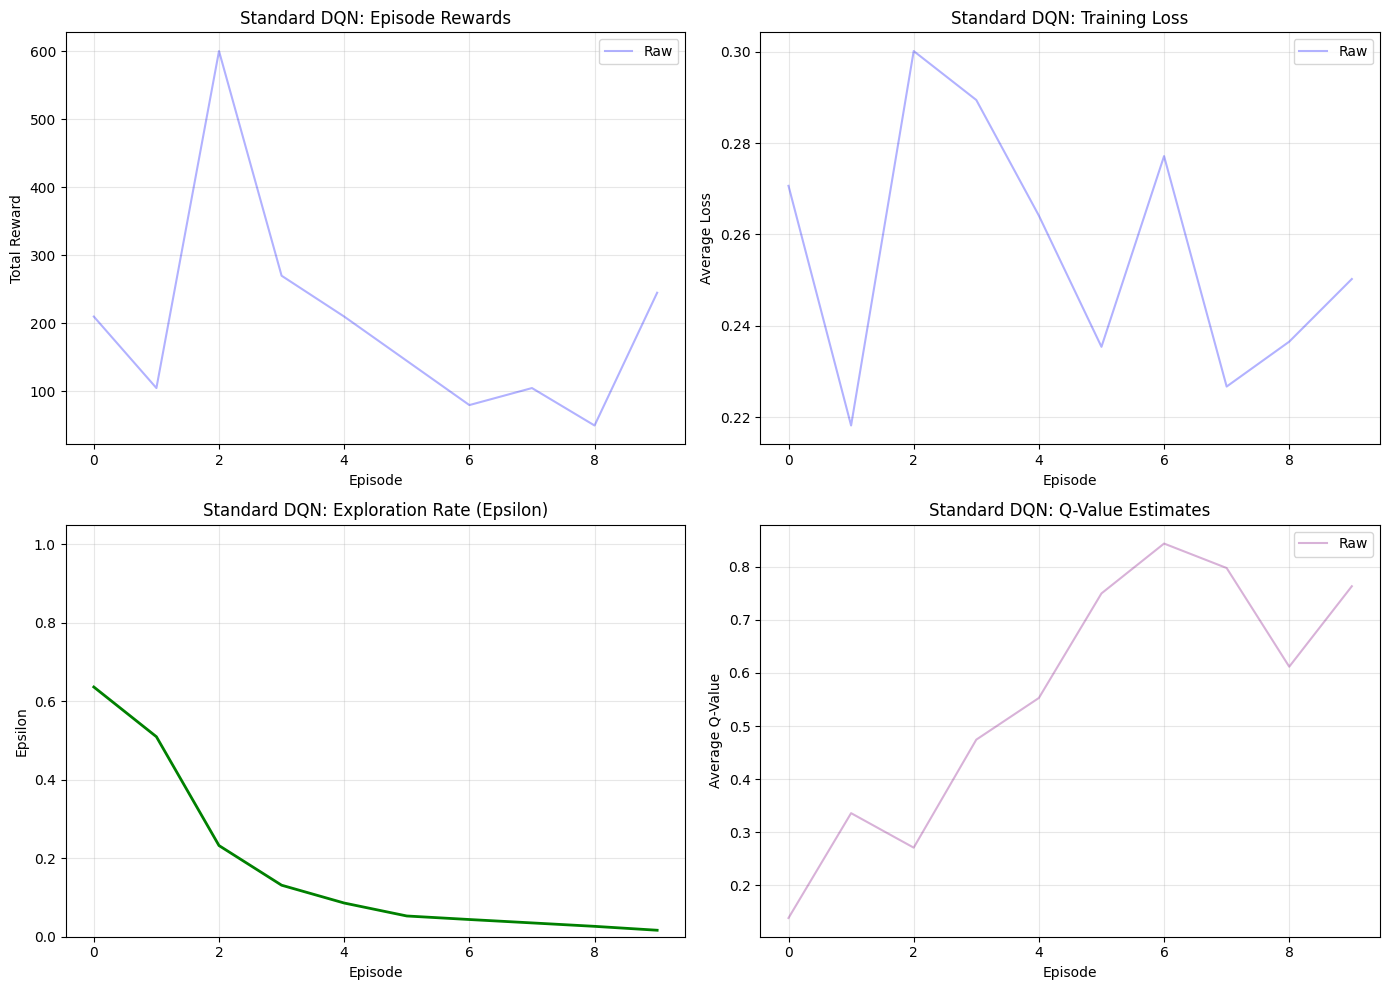

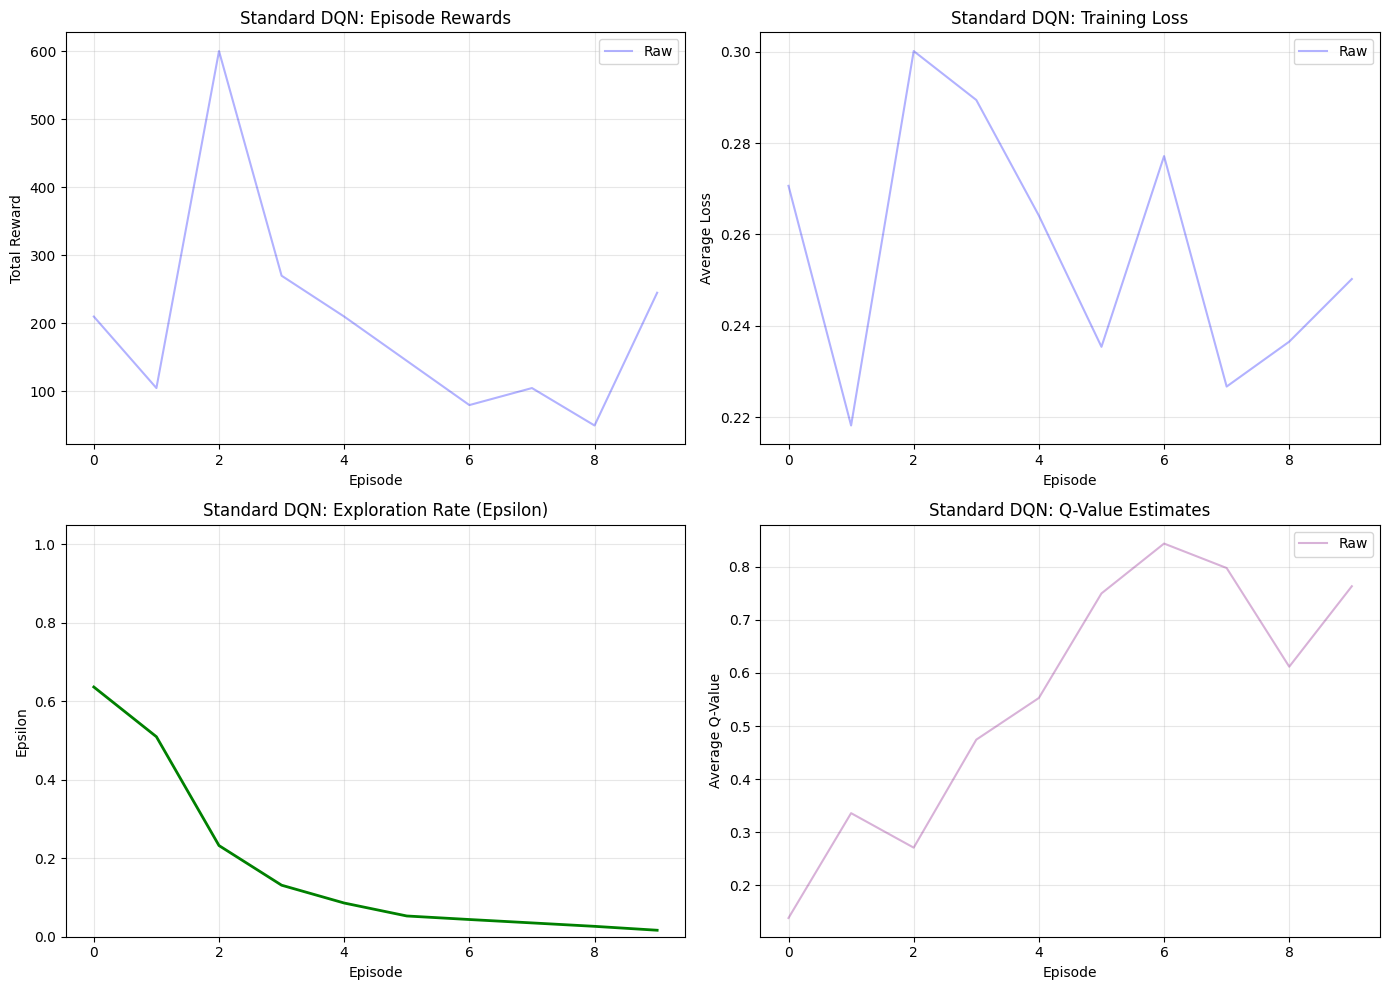

In [22]:
# Plot Standard DQN training curves
plot_training_curves(history_standard, title_prefix='Standard DQN', 
                    save_path='outputs/standard_dqn_training.png')

In [ ]:
# Train Double DQN
print("TRAINING DOUBLE DQN")

agent_double, history_double = train(
    episodes=1000,  # Adjust based on available time
    log_interval=10,
    double_dqn=True
)

TRAINING DOUBLE DQN
Training Double Dqn on cuda
Episode    0 | Reward:    110 | Avg100:   110.0 | Loss: 0.1375 | Epsilon: 0.735
Episode    1 | Reward:     95 | Avg100:   102.5 | Loss: 0.1558 | Epsilon: 0.544
Episode    2 | Reward:    375 | Avg100:   193.3 | Loss: 0.1672 | Epsilon: 0.319
Episode    3 | Reward:     55 | Avg100:   158.8 | Loss: 0.1839 | Epsilon: 0.258
Episode    4 | Reward:    465 | Avg100:   220.0 | Loss: 0.1984 | Epsilon: 0.151
Episode    5 | Reward:    325 | Avg100:   237.5 | Loss: 0.2150 | Epsilon: 0.092
Episode    6 | Reward:    105 | Avg100:   218.6 | Loss: 0.2183 | Epsilon: 0.059
Episode    7 | Reward:     80 | Avg100:   201.2 | Loss: 0.2185 | Epsilon: 0.042
Episode    8 | Reward:    305 | Avg100:   212.8 | Loss: 0.2201 | Epsilon: 0.023
Episode    9 | Reward:     15 | Avg100:   193.0 | Loss: 0.2208 | Epsilon: 0.017


Saved plot: outputs/double_dqn_training.png


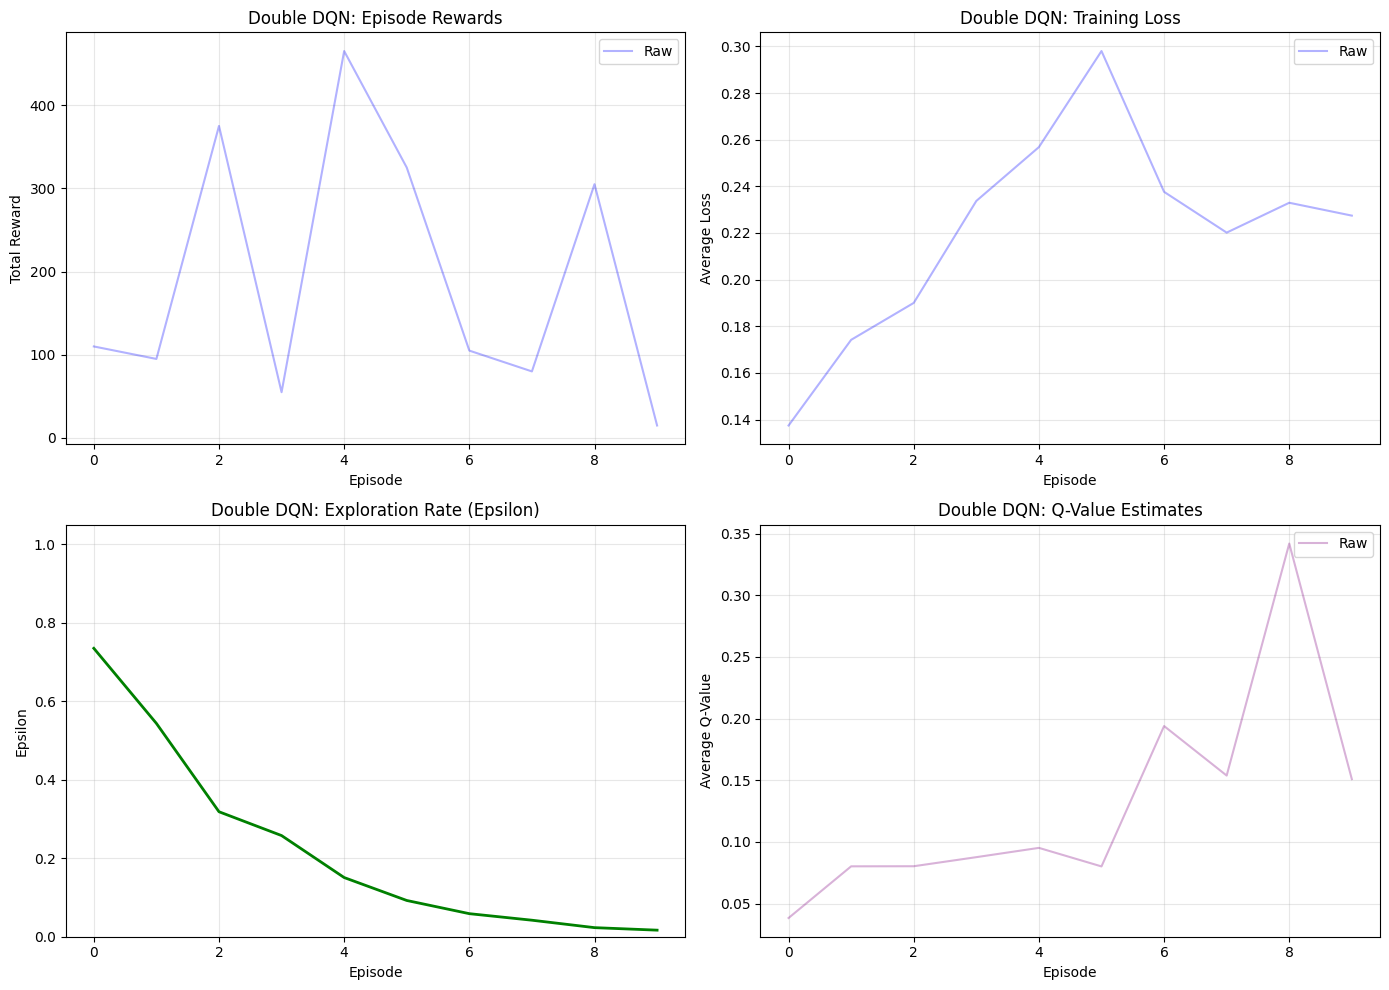

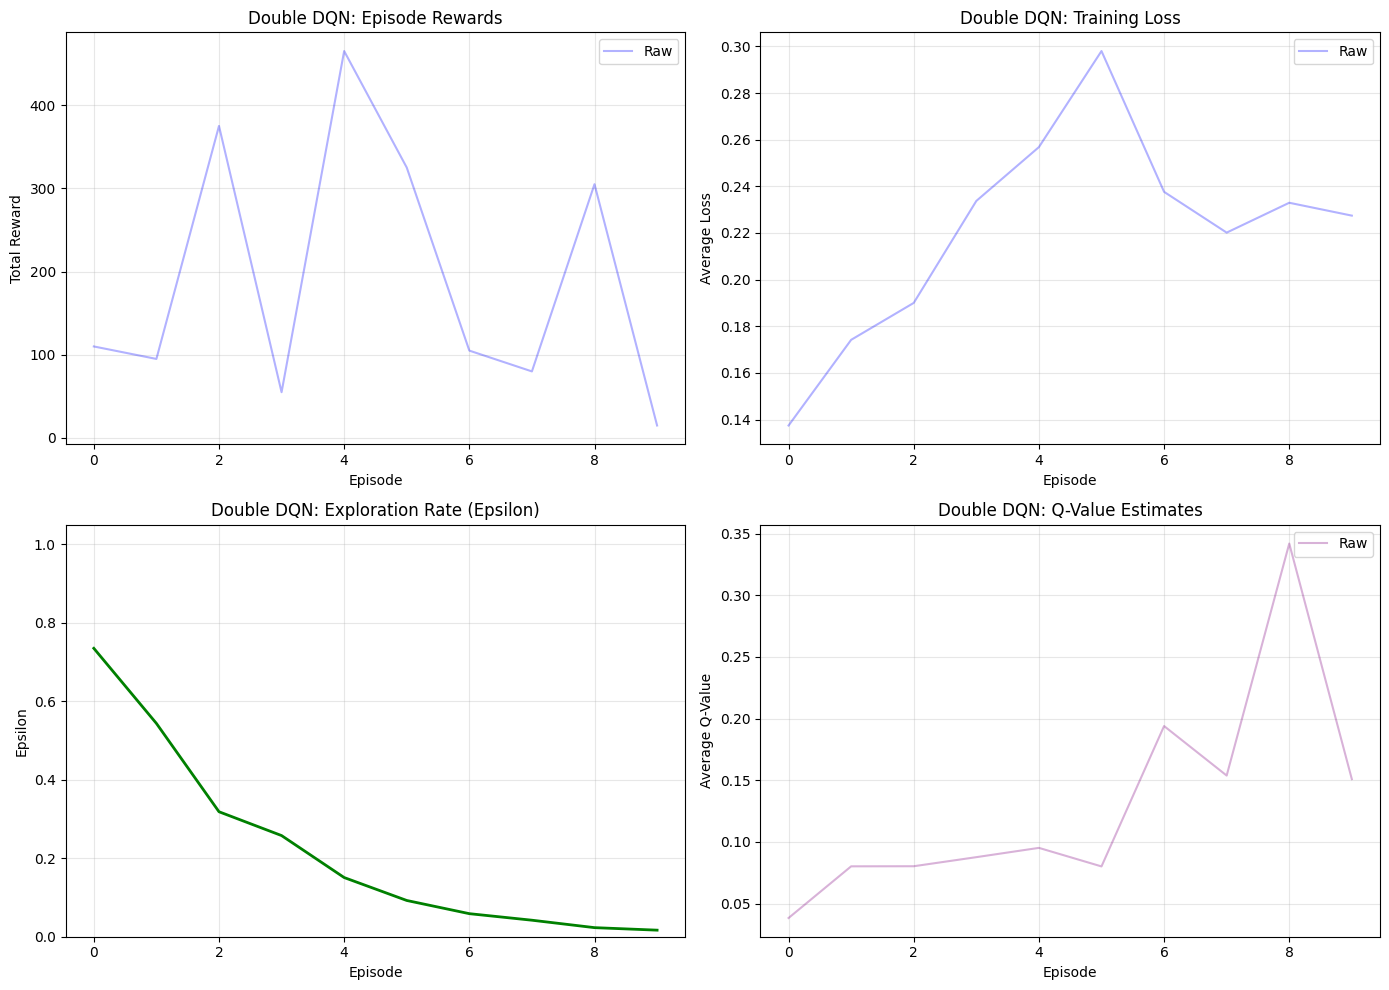

In [24]:
# Plot Double DQN training curves
plot_training_curves(history_double, title_prefix='Double DQN',
                    save_path='outputs/double_dqn_training.png')

/tmp/ipykernel_5938/1867877387.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_5938/1867877387.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


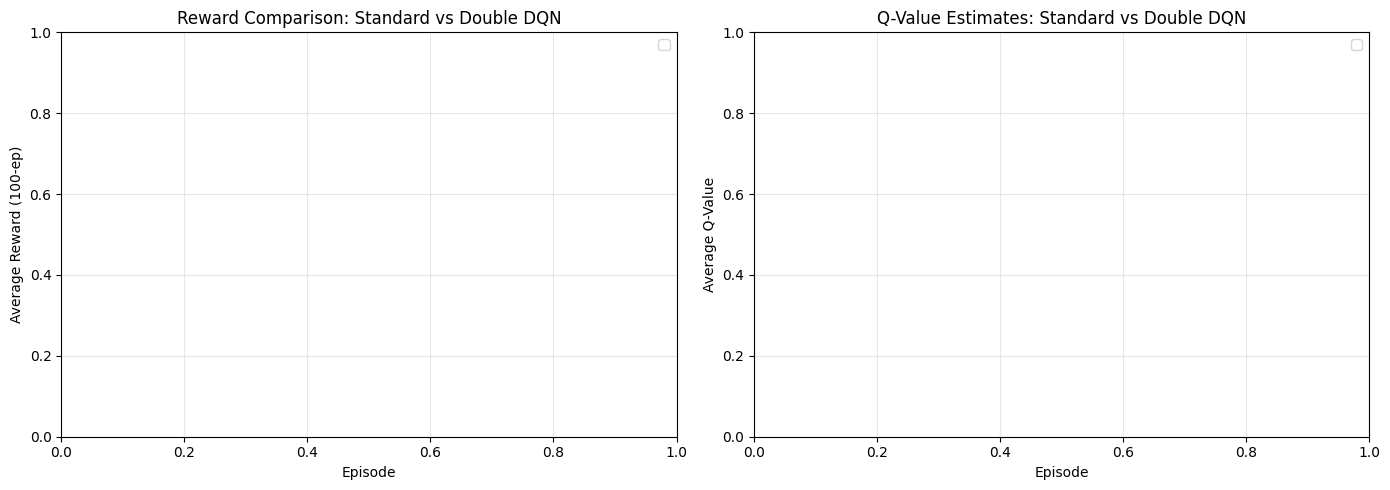


Training Summary:
Standard DQN - Final 100-ep avg: 202.0
Double DQN   - Final 100-ep avg: 193.0
Standard DQN - Max score: 600
Double DQN   - Max score: 465


In [ ]:
# Compare Standard vs Double DQN
plot_comparison(history_standard, history_double,
               save_path='outputs/dqn_comparison.png')

# Print summary statistics
print("\nTraining Summary:")
print(f"Standard DQN - Final 100-ep avg: {np.mean(history_standard['episode_rewards'][-100:]):.1f}")
print(f"Double DQN   - Final 100-ep avg: {np.mean(history_double['episode_rewards'][-100:]):.1f}")
print(f"Standard DQN - Max score: {max(history_standard['episode_rewards']):.0f}")
print(f"Double DQN   - Max score: {max(history_double['episode_rewards']):.0f}")

In [26]:
# Evaluate both agents
print("\nEvaluating Standard DQN:")
stats_standard = evaluate_agent(agent_standard, n_episodes=3)
compare_with_benchmarks(stats_standard['mean_reward'])

print("\nEvaluating Double DQN:")
stats_double = evaluate_agent(agent_double, n_episodes=3)
compare_with_benchmarks(stats_double['mean_reward'])


Evaluating Standard DQN:
  Episode 1/3: Reward = 170.0
  Episode 2/3: Reward = 105.0
  Episode 3/3: Reward = 230.0

Evaluation Results (3 episodes):
  Mean Reward:  168.3 ± 51.0
  Max Reward:   230
  Min Reward:   105
  Mean Length:  1038 steps

Benchmark Comparison:
----------------------------------------
  vs Random              :  112.2%
  vs Human               :   10.2%
  vs DQN (Nature)        :    8.5%
  vs Double DQN (Paper)  :    7.1%
----------------------------------------

Evaluating Double DQN:
  Episode 1/3: Reward = 205.0
  Episode 2/3: Reward = 175.0
  Episode 3/3: Reward = 215.0

Evaluation Results (3 episodes):
  Mean Reward:  198.3 ± 17.0
  Max Reward:   215
  Min Reward:   175
  Mean Length:  1094 steps

Benchmark Comparison:
----------------------------------------
  vs Random              :  132.2%
  vs Human               :   12.0%
  vs DQN (Nature)        :   10.0%
  vs Double DQN (Paper)  :    8.4%
----------------------------------------


In [27]:
# Record videos for demonstration
import imageio

# Random agent baseline
print("Recording random agent...")
record_random_agent('outputs/random_agent.mp4')

# Trained agents
print("\nRecording Standard DQN agent...")
record_video(agent_standard, 'outputs/standard_dqn_agent.mp4')

print("\nRecording Double DQN agent...")
record_video(agent_double, 'outputs/double_dqn_agent.mp4')

print("\nVideos saved to outputs/")

Recording random agent...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved random agent video: outputs/random_agent.mp4 (reward: 80.0)

Recording Standard DQN agent...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved video: outputs/standard_dqn_agent.mp4 (1404 frames, reward: 410.0)

Recording Double DQN agent...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved video: outputs/double_dqn_agent.mp4 (923 frames, reward: 220.0)

Videos saved to outputs/


### Analysis of Results

**Expected Observations:**

1. **Q-Value Estimates:** Double DQN should show lower Q-value estimates than Standard DQN because it reduces overestimation bias. Higher Q-values in Standard DQN don't mean better performance - they often indicate inflated estimates.

2. **Training Stability:** Double DQN typically shows more stable training curves with lower variance in episode rewards.

3. **Final Performance:** Double DQN often achieves higher final scores, particularly in games like Space Invaders where many actions have similar values.

4. **Video Analysis:** The trained agents should show strategic behavior like:
   - Positioning to avoid alien fire
   - Targeting specific aliens (higher rows for more points)
   - Using shields for cover
   - Attempting to hit the mystery ship when it appears

## 9. References

1. Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Hassabis, D. (2015). Human-level control through deep reinforcement learning. *Nature*, 518(7540), 529-533.

2. van Hasselt, H., Guez, A., & Silver, D. (2016). Deep reinforcement learning with double Q-learning. *Proceedings of the AAAI Conference on Artificial Intelligence*, 30(1).

3. Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.). MIT Press.

4. Gymnasium Documentation. https://gymnasium.farama.org/

5. CS4287 Lecture M: Deep Q-Networks for Atari Games.